<a href="https://colab.research.google.com/github/sebaspv/GANiversity/blob/main/GANiversity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the necessary libraries
import tensorflow as tf
import tensorflow.keras as keras
 
import matplotlib.pyplot as plt
import numpy as np

import zipfile
from IPython import display
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols*2, n_rows*2))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 16

In [ ]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.08,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.05,
    rotation_range = 5,
    horizontal_flip = True
)

In [ ]:
!ls

drive  sample_data


In [ ]:
image_dataset_generator = data_generator.flow_from_directory(
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    color_mode = 'rgb',
    class_mode = None,
    batch_size = BATCH_SIZE,
    directory = 'drive/MyDrive/logos/'
)

Found 474 images belonging to 1 classes.


In [ ]:
len(image_dataset_generator) # we have 15 batches of data, with 32 images each.

30

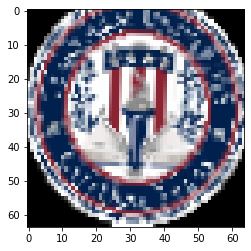

In [ ]:
# plot example image
for i in image_dataset_generator:
  plt.imshow(i[1])
  break

In [ ]:
# create generator
random_dimensions = 32
generator = keras.models.Sequential([
keras.layers.Dense(2*2*1024, input_shape = [random_dimensions]),
keras.layers.Reshape([2, 2, 1024]),
keras.layers.BatchNormalization(momentum = 0.5),
keras.layers.Conv2DTranspose(256, 5, 2, 'same', activation = 'selu'), # 4*4*512
keras.layers.Conv2DTranspose(128, 5, 2, 'same', activation = 'selu'), # 8*8*256
keras.layers.Conv2DTranspose(64, 5, 2, 'same', activation = 'selu'), # 16*16*128
keras.layers.Conv2DTranspose(32, 5, 2, 'same', activation = 'selu'), # 32*32*128
keras.layers.Conv2DTranspose(3, 5, 2, 'same', activation = 'tanh') # output (64*64*3)
])

In [ ]:
generator.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 4096)              135168    
_________________________________________________________________
reshape_11 (Reshape)         (None, 2, 2, 1024)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 2, 2, 1024)        4096      
_________________________________________________________________
conv2d_transpose_55 (Conv2DT (None, 4, 4, 256)         6553856   
_________________________________________________________________
conv2d_transpose_56 (Conv2DT (None, 8, 8, 128)         819328    
_________________________________________________________________
conv2d_transpose_57 (Conv2DT (None, 16, 16, 64)        204864    
_________________________________________________________________
conv2d_transpose_58 (Conv2DT (None, 32, 32, 32)      

In [ ]:
discriminator = keras.models.Sequential([
keras.layers.Conv2D(32, 5, 2, 'same', input_shape = [64, 64, 3], activation = keras.layers.LeakyReLU(alpha = 0.2)), # 64*32*32
keras.layers.Conv2D(64, 5, 2, 'same', activation = keras.layers.LeakyReLU(alpha = 0.2)), #16*16*128
keras.layers.Conv2D(128, 5, 2, 'same', activation = keras.layers.LeakyReLU(alpha = 0.2)), # 8*8*256
keras.layers.Conv2D(256, 5, 2, 'same', activation = keras.layers.LeakyReLU(alpha = 0.2)), # 4*4*512
keras.layers.Flatten(),
keras.layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
discriminator.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
flatten_11 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 4097      
Total params: 1,082,177
Trainable params: 1,082,177
Non-trainable params: 0
___________________________________________

In [ ]:
discriminator.compile(optimizer = keras.optimizers.Adam(lr = 0.0001, beta_1=0.5), loss = 'binary_crossentropy')
discriminator.trainable = False

In [ ]:
# compile all of the layers
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(lr = 0.0001, beta_1=0.5))

In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers
    number_of_batches = len(dataset)
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for i in range(number_of_batches):
            real_images = dataset.next()
            real_batch_size = real_images.shape[0]
            # random noise
            noise = tf.random.normal(shape = [real_batch_size, random_normal_dimensions])
          # Use the noise to generate fake images
            fake_images = generator(noise)
            mixed_images = tf.concat([fake_images, real_images], axis = 0)
            discriminator_labels = tf.constant([[0.]]*real_batch_size + [[.9]]*real_batch_size)
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            # PHASE 2 OF TRAINING
            noise = tf.random.normal([real_batch_size, random_normal_dimensions])
            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]]*real_batch_size)
            # Freeze the discriminator
            discriminator.trainable = False
            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        plot_results(np.array(fake_images), 16)                     
        plt.show()
    return fake_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

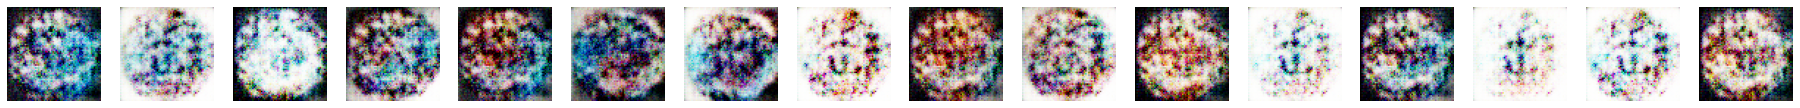

In [121]:
# you can change the number of epochs
EPOCHS = 10
 
# run the training loop and collect images
fake_images = train_gan(gan, image_dataset_generator, random_dimensions, EPOCHS)